In [ ]:

import kagglehub
jp797498e_twitter_entity_sentiment_analysis_path = kagglehub.dataset_download('jp797498e/twitter-entity-sentiment-analysis')

print('Data source import complete.')


import pandas as pd
import numpy as np
import os
import torch
import shutil
import socket
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

#CONFIGURACIÓN DE PARAMETROS

MODEL_NAME = 'vinai/bertweet-base'
# Update the TRAIN_PATH and VALID_PATH to use the path from kagglehub
TRAIN_PATH = os.path.join(jp797498e_twitter_entity_sentiment_analysis_path, 'twitter_training.csv')
VALID_PATH = os.path.join(jp797498e_twitter_entity_sentiment_analysis_path, 'twitter_validation.csv')
SAVE_DIR = '/kaggle/working/bertweet_sentiment_model'

os.makedirs(SAVE_DIR, exist_ok=True)

#PARAMETROS DE ENTRADA RED NEURONAL

MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 6
LEARNING_RATE = 2e-5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


#CARGA DE DATOS Y PREPROCESAMIENTO

def load_data(path):
    column_names = ["ID", "Entity", "Sentiment", "Tweet"]
    df = pd.read_csv(path, header=None, names=column_names)
    df['Sentiment'] = df['Sentiment'].replace({'Irrelevant': 'Neutral'})
    df.dropna(subset=['Tweet', 'Sentiment'], inplace=True)
    return df

train_df = load_data(TRAIN_PATH)
valid_df = load_data(VALID_PATH)

sentiment_map = {'Positive': 0, 'Negative': 1, 'Neutral': 2}
train_df['label'] = train_df['Sentiment'].map(sentiment_map)
valid_df['label'] = valid_df['Sentiment'].map(sentiment_map)

if train_df['label'].isnull().any() or valid_df['label'].isnull().any():
    print("Warning: Found unexpected sentiment labels!")
    print("Train NaNs:", train_df[train_df['label'].isnull()]['Sentiment'].unique())
    print("Valid NaNs:", valid_df[valid_df['label'].isnull()]['Sentiment'].unique())
    train_df.dropna(subset=['label'], inplace=True)
    valid_df.dropna(subset=['label'], inplace=True)
    train_df['label'] = train_df['label'].astype(int)
    valid_df['label'] = valid_df['label'].astype(int)

#Verificando que el BERT exista Y TOKENIZACION

def is_internet_available():
    try:
        socket.create_connection(("huggingface.co", 443), timeout=1)
        return True
    except OSError:
        return False

if is_internet_available():
    if os.path.exists(SAVE_DIR):
        shutil.rmtree(SAVE_DIR)
    os.makedirs(SAVE_DIR, exist_ok=True)

    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(sentiment_map))

    tokenizer.save_pretrained(SAVE_DIR)
    model.save_pretrained(SAVE_DIR)
else:
    tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
    model = AutoModelForSequenceClassification.from_pretrained(SAVE_DIR)

model.to(device)
if torch.cuda.device_count() > 1:
    model = DataParallel(model)

#PREPARACIÓN PARA LA RED NEURONAL (PREPARACION DEL DATASET)

class TwitterSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.texts = dataframe.Tweet.values
        self.entities = dataframe.Entity.values
        self.labels = dataframe.label.values
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        entity = str(self.entities[index])

        combined_text = text + " " + self.tokenizer.sep_token + " " + entity

        encoding = self.tokenizer.encode_plus(
            combined_text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[index], dtype=torch.long)
        }

train_dataset = TwitterSentimentDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = TwitterSentimentDataset(valid_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


#OPTIMIZADOR ADAM

optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(total_steps * 0.05)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=total_steps
)


#ENTRENAMIENTO Y VALIDACIÓN

def train_epoch(model, data_loader, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    predictions = []
    actual_labels = []

    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        if isinstance(model, DataParallel):
            loss = loss.mean()
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        actual_labels.extend(labels.cpu().numpy())

        progress_bar.set_postfix({'batch_loss': f'{loss.item():.4f}'})


    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(actual_labels, predictions)
    return avg_loss, accuracy

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    actual_labels = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            if isinstance(model, DataParallel):
                loss = loss.mean()
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            actual_labels.extend(labels.cpu().numpy())
            progress_bar.set_postfix({'batch_loss': f'{loss.item():.4f}'})


    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(actual_labels, predictions)
    return avg_loss, accuracy

## 8. Training Loop


best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')


    train_loss, train_acc = train_epoch(
        model,
        train_loader,
        optimizer,
        device,
        scheduler
    )
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')

    val_loss, val_acc = eval_model(
        model,
        valid_loader,
        device
    )
    print(f'Validation loss: {val_loss:.4f}, Validation accuracy (Top 1): {val_acc:.4f}')

    if val_acc > best_accuracy:
        print(f"Validation accuracy improved ({best_accuracy:.4f} -> {val_acc:.4f}). Saving model...")
        if isinstance(model, DataParallel):
            model_to_save = model.module
        else:
            model_to_save = model
        model_to_save.save_pretrained(SAVE_DIR)
        tokenizer.save_pretrained(SAVE_DIR)
        best_accuracy = val_acc

print("\nTraining complete.")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Data source import complete.
Using device: cuda


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/6


Training:   0%|          | 0/2313 [00:00<?, ?it/s]

Train loss: 0.6599, Train accuracy: 0.7163


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Validation loss: 0.2832, Validation accuracy (Top 1): 0.9020
Validation accuracy improved (0.0000 -> 0.9020). Saving model...

Epoch 2/6


Training:   0%|          | 0/2313 [00:00<?, ?it/s]

Train loss: 0.3123, Train accuracy: 0.8867


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Validation loss: 0.0917, Validation accuracy (Top 1): 0.9730
Validation accuracy improved (0.9020 -> 0.9730). Saving model...

Epoch 3/6


Training:   0%|          | 0/2313 [00:00<?, ?it/s]

Train loss: 0.1625, Train accuracy: 0.9435


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Validation loss: 0.0964, Validation accuracy (Top 1): 0.9770
Validation accuracy improved (0.9730 -> 0.9770). Saving model...

Epoch 4/6


Training:   0%|          | 0/2313 [00:00<?, ?it/s]

Train loss: 0.1067, Train accuracy: 0.9631


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Validation loss: 0.1171, Validation accuracy (Top 1): 0.9730

Epoch 5/6


Training:   0%|          | 0/2313 [00:00<?, ?it/s]

Train loss: 0.0761, Train accuracy: 0.9739


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Validation loss: 0.1097, Validation accuracy (Top 1): 0.9810
Validation accuracy improved (0.9770 -> 0.9810). Saving model...

Epoch 6/6


Training:   0%|          | 0/2313 [00:00<?, ?it/s]

Train loss: 0.0560, Train accuracy: 0.9797


Validation:   0%|          | 0/32 [00:00<?, ?it/s]

Validation loss: 0.1205, Validation accuracy (Top 1): 0.9810

Training complete.
Best validation accuracy: 0.9810


In [ ]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions = []
    actual_labels = []

    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="Validation", leave=False)
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            if isinstance(model, DataParallel):
                loss = loss.mean()
            total_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            actual_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    # === MÉTRICAS DE EVALUACIÓN ===
    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='weighted')
    recall = recall_score(actual_labels, predictions, average='weighted')
    f1 = f1_score(actual_labels, predictions, average='weighted')

    print("\n=== MÉTRICAS DE EVALUACIÓN ===")
    print(f"📌 Accuracy:  {accuracy:.4f}")
    print(f"📌 Precision: {precision:.4f}")
    print(f"📌 Recall:    {recall:.4f}")
    print(f"📌 F1 Score:  {f1:.4f}")

    print("\n📋 Reporte por clase:\n")
    print(classification_report(actual_labels, predictions, target_names=list(sentiment_map.keys())))

    # === MATRIZ DE CONFUSIÓN ===
    cm = confusion_matrix(actual_labels, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(sentiment_map.keys()),
                yticklabels=list(sentiment_map.keys()))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return avg_loss, accuracy




Validation:   0%|          | 0/32 [00:00<?, ?it/s]


=== MÉTRICAS DE EVALUACIÓN ===
📌 Accuracy:  0.9810
📌 Precision: 0.9811
📌 Recall:    0.9810
📌 F1 Score:  0.9810

📋 Reporte por clase:

              precision    recall  f1-score   support

    Positive       0.96      0.98      0.97       277
    Negative       0.99      0.98      0.99       266
     Neutral       0.98      0.98      0.98       457

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



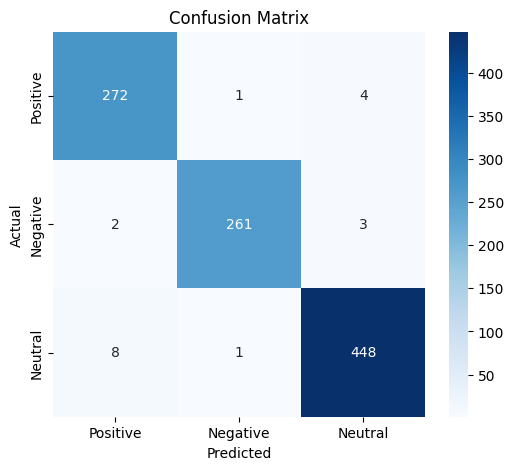

In [ ]:
# Evaluación final con el modelo ya entrenado
val_loss, val_acc = eval_model(model, valid_loader, device)
